In [2]:
# Import libraries

from astropy.io import ascii
import astropy.coordinates as coord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import EarthLocation, Angle, SkyCoord
from astropy.time import Time
from astropy.table import Table, unique
from datetime import datetime

In [3]:
# Functions

def check_date(message):
    '''
    Takes an inputted date and confirms that it is a valid future date.
    
    Parameters
    ----------
    message : str
        The message for the prompt, should accept a date in the form YYYY-MM-DD.

    Returns
    -------
    date : str
        The inputted valid date in YYYY-MM-DD format.
    '''
    # Get current date
    current_date = datetime.today()

    # Initially don't have a date
    have_date = False

    # Loop until given a valid date as input
    while have_date == False:
        # Get input and split into different parts
        date = input(message)
        try: 
            start_year = int(date[0:4])
            start_month = int(date[5:7])
            start_day = int(date[8:10])

            # Check if leap year
            if start_year % 4 == 0:
                if start_year % 400 != 0 and start_year % 100 == 0:
                    leap_year = False
                else:
                    leap_year = True
            else:
                leap_year = False

            # Check that the date is valid
            try:
                if (date[4] != '-') or (date[7] != '-') or (start_year < current_date.year) or (start_month > 12) or (start_month < current_date.month and start_year == current_date.year) or (start_day < current_date.day and start_month == current_date.month and start_year == current_date.year) or (start_month == 2 and leap_year == False and start_day > 28) or (start_month == 2 and leap_year == True and start_day > 29) or (start_day > 31) or ((start_month == 4 or start_month == 6 or start_month == 9 or start_month == 11) and start_day > 30) or (start_month <= 0) or (start_day <= 0):
                    print('Please provide a valid date in the future')
                else:
                    have_date = True
            except:
                print('Date not recognised please try again')
        
        except:
            print('Date not recognised please try again')

    return date

def check_time(message, secs=False):
    '''
    Takes an inputted timestamp and confirms that it is a valid timestamp.
    
    Parameters
    ----------
    message : str
        The message for the prompt, should accept a timestamp in the form HH:MM:SS.
    secs : bool
        Whether or not seconds are included, default False.

    Returns
    -------
    date : str
        The inputted valid timestamp in the inputted format.
    '''
    # Initially don't have a time
    have_time = False

    # Loop until given a valid time as input
    while have_time == False:
        # Get input and split into different parts
        time = input(message)
        try: 
            start_hour = int(time[0:2])
            start_minute = int(time[3:5])
            if secs == True:
                start_second = int(time[6:8])

            # Check that the date is valid
            try:
                if (time[2] != ':') or (start_hour > 23) or (start_minute > 59):
                    if secs == True and ((time[5] != ':') or start_second > 59):
                        print('Please provide a valid time')
                else:
                    have_time = True
            except:
                print('Time not recognised please try again')
                print('1')
        except:
            print('Time not recognised please try again')
            print('2')

    return time

def get_lst(loc, utc, name=None):
    '''
    Gets the LST at a point on the Earth's surface at a given time and prints it if given a name for the location, otherwise it returns the LST.

    Parameters
    ----------
    loc : EarthLocation
        The location in astropy EarthLocation format.
    utc
        The time and date in UTC that the LST is to be found at.
    name : str
        The name of the location that the LST is to be found at, default None.
    
    Returns
    -------
    lst
        The local siderial time at that location and time.
    '''
    time = Time(utc, scale='utc', location=loc)
    lst = time.sidereal_time('mean')
    if name != None: 
        print(f'The local siderial time at {name} at UTC: {utc} is: ' + str(lst))
    else:
        return lst
    
def check_file(message, columns=None):
    '''
    Checks an inputted path to a CSV and attempts to keep the specified columns, if none are specified, all columns are kept.

    Parameters
    ----------
    message : str
        The propmt for the CSV file to be dealt with.
    columns : array likee
        The list of columns to be kept in the CSV, None.
    Returns
    -------
    table
        An astropy table from the CSV.
    '''
    # Initially don't have a valid file
    have_file = False
    
    file = input(message)

    # If the file is valid we can quit, otherwise it tries again
    try:
        table = ascii.read(file)
        if columns != None:
            table.keep_columns(columns)
        have_file = True
    except:
        print('File name not recognised, please try again')
        check_file
    
    return table

In [4]:
##################################
#                                #
#   Set up times and locations   #
#                                #
##################################


valid_dates = False
valid_times = False

# Check that dates and times are in the right order
while valid_dates == False:
    start_date = check_date('Please enter starting date of observation (YYYY-MM-DD): ')
    end_date = check_date('Please enter ending date of observation (YYYY-MM-DD): ')

    if (int(start_date[0:4]) > int(end_date[0:4])) or (int(start_date[0:4]) == int(end_date[0:4]) and int(start_date[5:7]) > int(end_date[5:7])) or (start_date[0:4] == end_date[0:4] and start_date[5:7] == end_date[5:7] and int(start_date[8:10]) > int(end_date[8:10])):
        print('End date must be the same or later than the start date')
    else:
        valid_dates = True

while valid_times == False:
    start_time = check_time('Please enter starting time of observation (HH:MM:SS): ', True)
    end_time = check_time('Please enter ending time of observation (HH:MM:SS): ', True)

    if start_date == end_date:
        if (start_time == end_time) or (int(start_time[0:2]) > int(end_time[0:2])) or (int(start_time[0:2]) == int(end_time[0:2]) and int(start_time[3:5]) > int(end_time[3:5])) or (int(start_time[0:2]) == int(end_time[0:2]) and int(start_time[3:5]) == int(end_time[3:5]) and int(start_time[6:8]) >= int(end_time[6:8])):
            print('End time must be later than the start time')
        else:
            valid_times = True
    else:
        valid_times = True


starting = start_date + ' ' + start_time
ending = end_date + ' ' + end_time

starting_time = Time(starting, scale='utc')
ending_time = Time(ending, scale='utc')

# Birr
birr_loc = EarthLocation(lat=53.095*u.deg, lon=-7.922*u.deg)

# Onsala
onsala_loc = EarthLocation(lat=57.399*u.deg, lon=11.930*u.deg)


# Midpoint
mid_lon = (birr_loc.lon + onsala_loc.lon) / 2
mid_lat = (birr_loc.lat + onsala_loc.lat) / 2
mid_loc = EarthLocation(lat=mid_lat, lon=mid_lon)
LST_start_mid = get_lst(mid_loc, starting)
LST_end_mid = get_lst(mid_loc, ending)

print('Starting LST at midpoint:', LST_start_mid)
get_lst(birr_loc, starting, 'Birr')
get_lst(onsala_loc, starting, 'Onsala')


print('\n')

print('Ending LST at midpoint:', LST_end_mid)
get_lst(birr_loc, ending, 'Birr')
get_lst(onsala_loc, ending, 'Onsala')

Starting LST at midpoint: 14h53m24.34393019s
The local siderial time at Birr at UTC: 2024-07-02 20:00:00 is: 14h13m42.10393019s
The local siderial time at Onsala at UTC: 2024-07-02 20:00:00 is: 15h33m06.58393018s


Ending LST at midpoint: 22h53m43.03172736s
The local siderial time at Birr at UTC: 2024-07-03 03:59:00 is: 22h14m00.79172737s
The local siderial time at Onsala at UTC: 2024-07-03 03:59:00 is: 23h33m25.27172735s


In [5]:
# Import data and clean it up

# Exoplanet data
planets = check_file('Path to CSV file containing exoplanet hostname, coordinates and distances in NASA exoplanet database format: ', ['hostname', 'ra', 'dec', 'sy_dist'])

# One planet per host
planets = unique(planets, 'hostname')

# Sort by distance
planets.sort(keys='sy_dist')

# Get pulsar data
pulsars = check_file('Path to CSV file containing pulsar names, coordinates and luminosities in ATNF format: ', ['NAME', 'RAJ', 'DECJ', 'R_LUM'])

# Remove rows without luminosities
ind = pulsars['R_LUM'] != '*'
pulsars = pulsars[ind]

# Convert luminosities to floats
luminosities = np.array([])

for i in range(len(pulsars['R_LUM'])):
    base, exp = pulsars['R_LUM'][i].split('E')
    lum = float(base) * 10**float(exp)
    luminosities = np.append(luminosities, lum)

pulsars['R_LUM'] = luminosities

# Best to observe within 40 minutes of zenith
start_obs_psr = Angle(pulsars['RAJ'], u.hourangle).degree - 10

pulsars['start_obs'] = start_obs_psr

coords_psr = coord.SkyCoord(ra=pulsars['RAJ'], dec=pulsars['DECJ'], unit=(u.hourangle, u.deg))

In [6]:
# Optimise for closest to zenith at the middle of the observation window

# How long we'll point at a planet or pulsar
pointing_time_planet = check_time('Time to spend observing a planet (HH:MM): ')
pointing_time_planet = (int(pointing_time_planet[0:2])*u.hr + int(pointing_time_planet[3:5])*u.min + 1*u.min).to(u.hr).value

# Copy of planets that we can delete stuff from
planets_copy = Table(planets, copy=True)

time_LST = LST_start_mid.value
time_offset = 0
target_list = []
target_type = []

# The coordinates of the planets
planets_ra = np.array(planets['ra'])
planets_dec = np.array(planets['dec'])

planets_coords = SkyCoord(ra=planets_ra, dec=planets_dec, unit='deg')

# How long from the start we will observe for
obs_time = (ending_time.mjd - starting_time.mjd) * 24 # hours


# Go for obs_time hours
while time_offset <= obs_time:

    # Find the RA that is directly overhead in the middle of the observation window
    mid_lst = (time_LST + pointing_time_planet/2) * 15

    # Find target that is closest to the zenith at the middle of the observation window
    zenith = SkyCoord(ra=mid_lst, dec=mid_lat, unit='deg')
    sep = zenith.separation(planets_coords)
    ind = np.argmin(sep)
    target_list.append(planets_copy['hostname'][ind])

    # Delete that index from the coordinates array and the copy table to prevent repeats
    planets_coords = np.delete(planets_coords, ind)
    planets_copy.remove_row(ind)
    
    # Move on
    time_offset += pointing_time_planet
    time_LST += pointing_time_planet

# Output target list
print(target_list)

['TOI-2048', 'TOI-2081', 'TOI-2180', 'TOI-2010', 'TOI-1431', 'TOI-1386']


In [7]:
# Get smallest value of distance times separation from zenith

# How long we'll point at a planet or pulsar
#pointing_time_planet = check_time('Time to spend observing a planet (HH:MM): ')
#pointing_time_planet = (int(pointing_time_planet[0:2])*u.hr + int(pointing_time_planet[3:5])*u.min + 1*u.min).to(u.hr).value

# Copy of planets that we can delete stuff from
planets_copy = Table(planets, copy=True)

time_LST = LST_start_mid.value
time_offset = 0
target_list_times = []
target_type = []

# The coordinates of the planets
planets_ra = np.array(planets['ra'])
planets_dec = np.array(planets['dec'])

planets_coords = SkyCoord(ra=planets_ra, dec=planets_dec, unit='deg')

# How long from the start we will observe for
obs_time = (ending_time.mjd - starting_time.mjd) * 24 # hours


# Go for obs_time hours
while time_offset <= obs_time:

    # Find the RA that is directly overhead in the middle of the observation window
    mid_lst = (time_LST + pointing_time_planet/2) * 15

    # Find target that is closest to the zenith at the middle of the observation window
    zenith = SkyCoord(ra=mid_lst, dec=mid_lat, unit='deg')
    sep = zenith.separation(planets_coords)
    sep_dist = np.array(sep * planets_copy['sy_dist'])
    ind = np.argmin(sep_dist)
    target_list_times.append(planets_copy['hostname'][ind])

    # Delete that index from the coordinates array and the copy table to prevent repeats
    planets_coords = np.delete(planets_coords, ind)
    planets_copy.remove_row(ind)
    
    # Move on
    time_offset += pointing_time_planet
    time_LST += pointing_time_planet

# Output target list
print(target_list_times)

['TOI-1411', 'TOI-1450 A', 'WD 1856+534', 'HD 235088', 'GJ 806', 'TOI-1386']


In [8]:
# Get smallest value of distance plus separation from zenith

# How long we'll point at a planet or pulsar
#pointing_time_planet = check_time('Time to spend observing a planet (HH:MM): ')
#pointing_time_planet = (int(pointing_time_planet[0:2])*u.hr + int(pointing_time_planet[3:5])*u.min + 1*u.min).to(u.hr).value

# Copy of planets that we can delete stuff from
planets_copy = Table(planets, copy=True)

time_LST = LST_start_mid.value
time_offset = 0
target_list_plus = []
target_type = []

# The coordinates of the planets
planets_ra = np.array(planets['ra'])
planets_dec = np.array(planets['dec'])

planets_coords = SkyCoord(ra=planets_ra, dec=planets_dec, unit='deg')

# How long from the start we will observe for
obs_time = (ending_time.mjd - starting_time.mjd) * 24 # hours


# Go for obs_time hours
while time_offset <= obs_time:

    # Find the RA that is directly overhead in the middle of the observation window
    mid_lst = (time_LST + pointing_time_planet/2) * 15

    # Find target that is closest to the zenith at the middle of the observation window
    zenith = SkyCoord(ra=mid_lst, dec=mid_lat, unit='deg')
    sep = zenith.separation(planets_coords)
    sep_dist = np.array(sep.value + planets_copy['sy_dist'])
    ind = np.argmin(sep_dist)
    target_list_plus.append(planets_copy['hostname'][ind])

    # Delete that index from the coordinates array and the copy table to prevent repeats
    planets_coords = np.delete(planets_coords, ind)
    planets_copy.remove_row(ind)
    
    # Move on
    time_offset += pointing_time_planet
    time_LST += pointing_time_planet

# Output target list
print(target_list_plus)

['TOI-1411', 'TOI-1450 A', 'WD 1856+534', 'GJ 806', 'TOI-6008', 'TOI-2285']


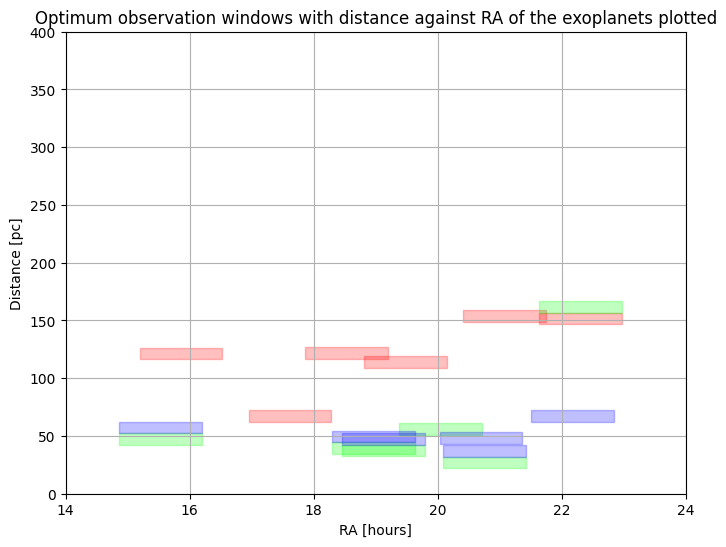

In [9]:
# Plot the optimum viewing windows for the targets
fig, ax = plt.subplots(figsize=(8,6))

'''# All planets
for i in range(len(planets['ra'])):
    # Plot from optimum start time of observation to +20 degrees (1 hr 20 mins)
    ax.broken_barh([(planets['ra'][i] - 10, 20)], (planets['sy_dist'][i], 10))'''

# Targeted planets in a different colour
for i in range(len(target_list)):
    index = planets['hostname'] == target_list[i]
    if sum(index) != 0:
        ind = np.argwhere(index)[0][0]

        # Plot from optimum start time of observation to +20 degrees (1 hr 20 mins)
        ax.broken_barh([(planets['ra'][ind] - 10, 20)], (planets['sy_dist'][ind], 10), color=[1, 0, 0, 0.25])
        #ax.text(planets['ra'][ind]+0.5 - 10, planets['sy_dist'][ind], planets['hostname'][ind])

for i in range(len(target_list)):
    index = planets['hostname'] == target_list_times[i]
    if sum(index) != 0:
        ind = np.argwhere(index)[0][0]

        # Plot from optimum start time of observation to +20 degrees (1 hr 20 mins)
        ax.broken_barh([(planets['ra'][ind] - 10, 20)], (planets['sy_dist'][ind] + 10, 10), color=[0, 1, 0, 0.25])
        #ax.text(planets['ra'][ind]+0.5 - 10, planets['sy_dist'][ind], planets['hostname'][ind])

for i in range(len(target_list)):
    index = planets['hostname'] == target_list_plus[i]
    if sum(index) != 0:
        ind = np.argwhere(index)[0][0]

        # Plot from optimum start time of observation to +20 degrees (1 hr 20 mins)
        ax.broken_barh([(planets['ra'][ind] - 10, 20)], (planets['sy_dist'][ind] + 20, 10), color=[0, 0, 1, 0.25])
        #ax.text(planets['ra'][ind]+0.5 - 10, planets['sy_dist'][ind], planets['hostname'][ind])


ax.set_xticks(np.arange(0, 361, 30))
ax.set_xticklabels(np.arange(0, 25, 2))
ax.grid(True)
ax.set_xlabel('RA [hours]')
ax.set_ylabel('Distance [pc]')
ax.set_title('Optimum observation windows with distance against RA of the exoplanets plotted')
ax.set_xlim([14*15, 24*15])
ax.set_ylim([0, 400])
plt.show()

(210.0, 360.0)

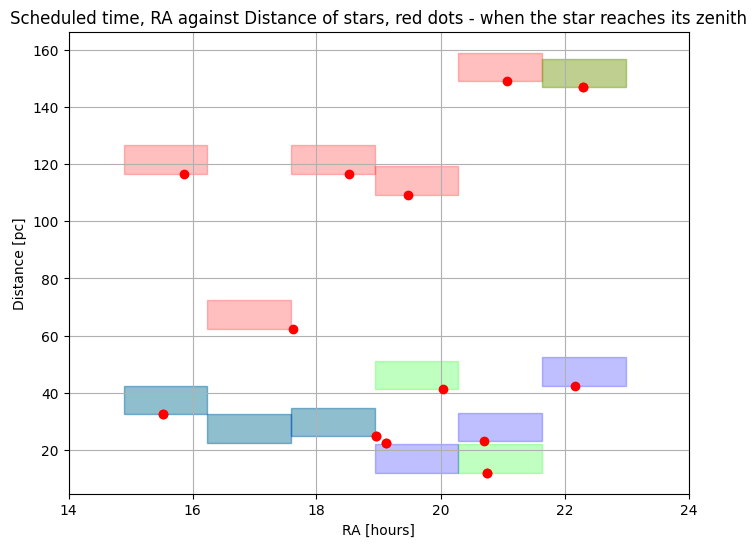

In [10]:
# Plot Actual viewing times
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(True)

start_deg = LST_start_mid.value * 360/24

# Initially don't take into account the pulsar observation
pulsar_offset = 0

pulsar_obs = False

for i in range(len(target_list)):
    # Plot from start time of observation to +20 degrees (1 hr 20 mins)
    index = planets['hostname'] == target_list[i]
    ind = np.argwhere(index)[0][0]

    # Plot at [len of planet observation * no planets already observed in hours + the initial offset as not starting from 0 + 1 minute for each wait + the offest due to the pulsar observation if necessary]
    ax.broken_barh([(pointing_time_planet * i * 15 + start_deg + pulsar_offset, pointing_time_planet * 15)], (planets['sy_dist'][ind], 10), color=[1, 0, 0, 0.25])
    #ax.text(pointing_time_planet * i * 15 + start_deg + pulsar_offset, planets['sy_dist'][ind], planets['hostname'][ind])
    ax.plot(planets['ra'][ind], planets['sy_dist'][ind], 'ro')

for i in range(len(target_list_times)):
    # Plot from start time of observation to +20 degrees (1 hr 20 mins)
    index = planets['hostname'] == target_list_times[i]
    ind = np.argwhere(index)[0][0]

    # Plot at [len of planet observation * no planets already observed in hours + the initial offset as not starting from 0 + 1 minute for each wait + the offest due to the pulsar observation if necessary]
    ax.broken_barh([(pointing_time_planet * i * 15 + start_deg + pulsar_offset, pointing_time_planet * 15)], (planets['sy_dist'][ind], 10), color=[0, 1, 0, 0.25])
    #ax.text(pointing_time_planet * i * 15 + start_deg + pulsar_offset, planets['sy_dist'][ind], planets['hostname'][ind])
    ax.plot(planets['ra'][ind], planets['sy_dist'][ind], 'ro')

for i in range(len(target_list_plus)):
    # Plot from start time of observation to +20 degrees (1 hr 20 mins)
    index = planets['hostname'] == target_list_plus[i]
    ind = np.argwhere(index)[0][0]

    # Plot at [len of planet observation * no planets already observed in hours + the initial offset as not starting from 0 + 1 minute for each wait + the offest due to the pulsar observation if necessary]
    ax.broken_barh([(pointing_time_planet * i * 15 + start_deg + pulsar_offset, pointing_time_planet * 15)], (planets['sy_dist'][ind], 10), color=[0, 0, 1, 0.25])
    #ax.text(pointing_time_planet * i * 15 + start_deg + pulsar_offset, planets['sy_dist'][ind], planets['hostname'][ind])
    ax.plot(planets['ra'][ind], planets['sy_dist'][ind], 'ro')

ax.set_xticks(np.arange(0, 361, 30))
ax.set_xticklabels(np.arange(0, 25, 2))
ax.set_xlabel('RA [hours]')
ax.set_ylabel('Distance [pc]')
ax.set_title('Scheduled time, RA against Distance of stars, red dots - when the star reaches its zenith')


ax.set_xlim([14*15, 24*15])
#ax.set_ylim([0, 400])

In [29]:
# Output schedule with pointings and timings in iLiSA format
sched_iLiSA = Table(names=('Name', 'Time', 'RA', 'DEC'), dtype=(str, str, float, float))

time = starting_time.mjd

for i in range(len(target_list)):
    index = planets['hostname'] == target_list[i]
    ind = np.argwhere(index)[0][0]

    sched_iLiSA.add_row((planets['hostname'][ind], Time(time, format='mjd').iso[11:16], planets['ra'][ind]*u.deg.to(u.rad), planets['dec'][ind]*u.deg.to(u.rad)))

    # Wait the 1 hr 21 minutes
    time += pointing_time_planet/24     

# Take same frequency range for all observations

have_freq_range = False

while have_freq_range == False:

    try:
        min_freq = float(input('Please give the minimum frequency you\'d like to observe at (in MHz): '))
        max_freq = float(input('Please give the maximum frequency you\'d like to observe at (in MHz): '))
        have_freq_range = True
    except:
        print('Please enter a valid frequency')

freq_range = str(min_freq) + 'e6:' + str(max_freq) + 'e6'

sched_iLiSA['freqrng'] = freq_range

# Get the duration

dur = str(int(np.round((pointing_time_planet - 1/60) * 60))) + 'm'

sched_iLiSA['dur'] = dur

In [25]:
sched_realta = Table(names=('start', '-', 'stop', ':', 'name', 'coords'), dtype=(str, str, str, str, str, list))

time = starting_time.mjd

for i in range(len(target_list)):
    index = planets['hostname'] == target_list[i]
    ind = np.argwhere(index)[0][0]

    end_time = time + (pointing_time_planet - 1/60)/24

    sched_realta.add_row((Time(time, format='mjd').iso, '-', Time(end_time, format='mjd').iso, ':', planets['hostname'][ind], [planets['ra'][ind]*u.deg.to(u.rad), planets['dec'][ind]*u.deg.to(u.rad), 'J2000']))

    # Wait the 1 hr 21 minutes
    time += pointing_time_planet/24     


In [26]:
sched_realta

start,-,stop,:,name,coords
str23,str1,str23,str1,str8,object
2024-07-02 20:00:00.000,-,2024-07-02 21:20:00.000,:,TOI-2048,"[4.152559030035971, 0.9129172993982378, 'J2000']"
2024-07-02 21:21:00.000,-,2024-07-02 22:41:00.000,:,TOI-2081,"[4.612944716803303, 0.925470724905535, 'J2000']"
2024-07-02 22:42:00.000,-,2024-07-03 00:02:00.000,:,TOI-2180,"[4.851031478444886, 0.9887408702950795, 'J2000']"
2024-07-03 00:03:00.000,-,2024-07-03 01:23:00.000,:,TOI-2010,"[5.099275098147319, 0.9335307042604639, 'J2000']"
2024-07-03 01:24:00.000,-,2024-07-03 02:44:00.000,:,TOI-1431,"[5.518795535852711, 0.9701940103163726, 'J2000']"
2024-07-03 02:45:00.000,-,2024-07-03 04:05:00.000,:,TOI-1386,"[5.838197957034913, 0.9480461887702802, 'J2000']"


In [30]:
sched_iLiSA

Name,Time,RA,DEC,freqrng,dur
str8,str5,float64,float64,str15,str3
TOI-2048,20:00,4.152559030035971,0.9129172993982378,100.0e6:190.0e6,80m
TOI-2081,21:21,4.612944716803303,0.925470724905535,100.0e6:190.0e6,80m
TOI-2180,22:42,4.851031478444886,0.9887408702950795,100.0e6:190.0e6,80m
TOI-2010,00:03,5.099275098147319,0.9335307042604639,100.0e6:190.0e6,80m
TOI-1431,01:24,5.518795535852711,0.9701940103163726,100.0e6:190.0e6,80m
TOI-1386,02:45,5.838197957034913,0.9480461887702802,100.0e6:190.0e6,80m
